<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Settings" data-toc-modified-id="Imports-and-Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Settings</a></span></li><li><span><a href="#Configure-Variables" data-toc-modified-id="Configure-Variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configure Variables</a></span></li><li><span><a href="#Begin-Analysis" data-toc-modified-id="Begin-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Begin Analysis</a></span></li></ul></div>

# Imports and Settings

In [1]:
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier
from notebook_functions import *

2023-02-13 10:56:01.510178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Configure Variables

In [5]:
data = pd.read_csv("annotated_data/duke_v2.csv")
color_channel_to_use = "YL1"
use_stain_in_AutoGater = False

point_1_that_defines_soa_line=(3.25, 4.5)
point_2_that_defines_soa_line=(4, 6.25)

# Begin Analysis

In [6]:
df = data.loc[data["stain"] == 1]

In [7]:
stain_cols = ["{}-A".format(color_channel_to_use), 
              "{}-H".format(color_channel_to_use),
              "{}-W".format(color_channel_to_use)]
all_features = n.morph_cols + stain_cols

if use_stain_in_AutoGater:
    features = all_features
else:
    features = n.morph_cols
    
print("Features that AutoGater will use: {}".format(features))

Features that AutoGater will use: ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']


In [8]:
df_with_rfc_labels, X, Y = generate_rf_labels_from_conditions(df, features,
                                                             live_conditions=[{'inducer_concentration': 0.0,
                                                                               'timepoint': 0.0},
                                                                              {'inducer_concentration': 0.0,
                                                                               'timepoint': 3.0},
                                                                               {'inducer_concentration': 0.0,
                                                                                'timepoint': 6.0},
                                                                               {'inducer_concentration': 5.0,
                                                                                'timepoint': 3.0}])

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 0.0}, {'inducer_concentration': 0.0, 'timepoint': 3.0}, {'inducer_concentration': 0.0, 'timepoint': 6.0}, {'inducer_concentration': 5.0, 'timepoint': 3.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 10:56:09
Starting Classification training...
Training time was: 14.31 seconds
Testing time was: 1.87 seconds
Prediction time of untested data was: 9.893873929977417
Run finished at 10:56:38. Total run time = 29.33 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




2023-02-13 10:56:39.596886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


25078/25078 [==============================] - 58s 2ms/step

Model Boosting took 465.731516122818 seconds
Training Accuracy = 60.94%
Counter({0: 563874, 1: 238609})
25078/25078 [==============================] - 59s 2ms/step


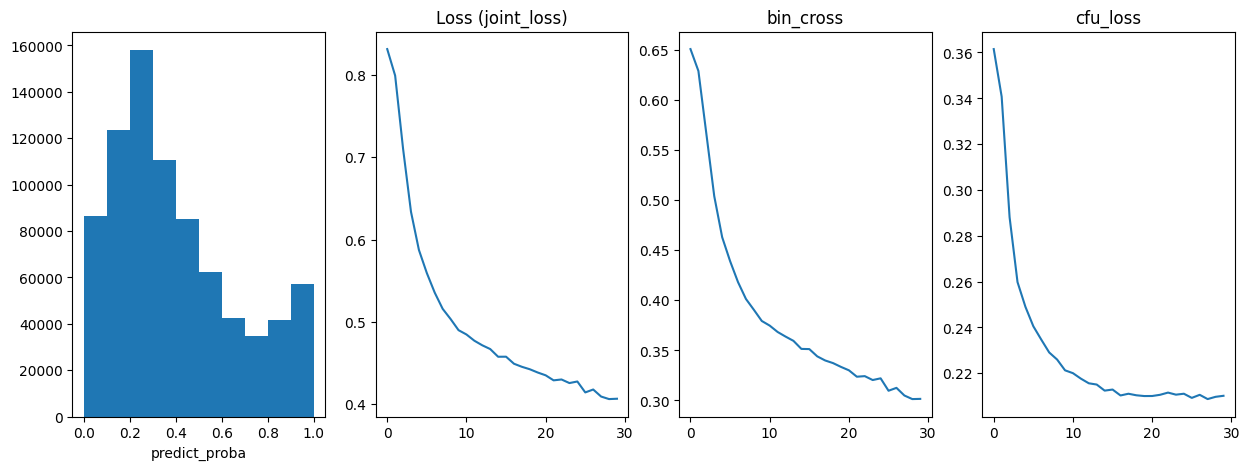

In [9]:
condition_results, preds_and_labels,model = run_model(model_function=booster_model_v2, lr=0.001,
                                                loss = joint_loss_wrapper(0.5), 
                                                metrics = [bin_cross, cfu_loss],
                                                X = X, Y = Y, epochs = 30, batch_size = 2048,
                                                verbose = False, shuffle = True, plot_type="line")

In [10]:
model.model.save("autogater_ethanol")

INFO:tensorflow:Assets written to: autogater_ethanol/assets


INFO:tensorflow:Assets written to: autogater_ethanol/assets


In [11]:
X.to_csv('data_for_nn.to_csv')
Y.to_csv('labels_for_nn.to_csv')

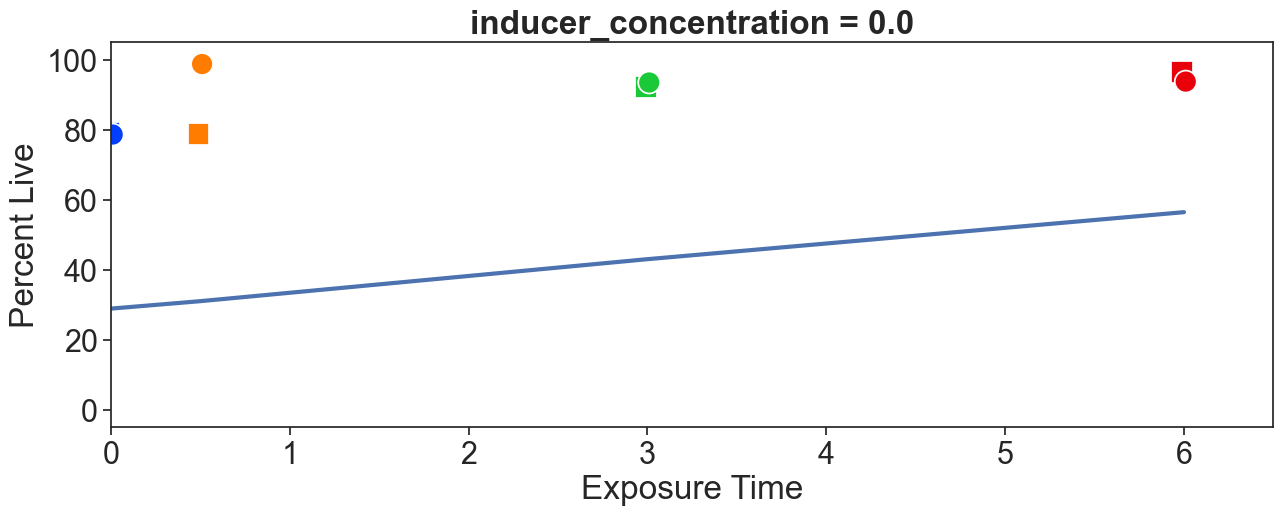

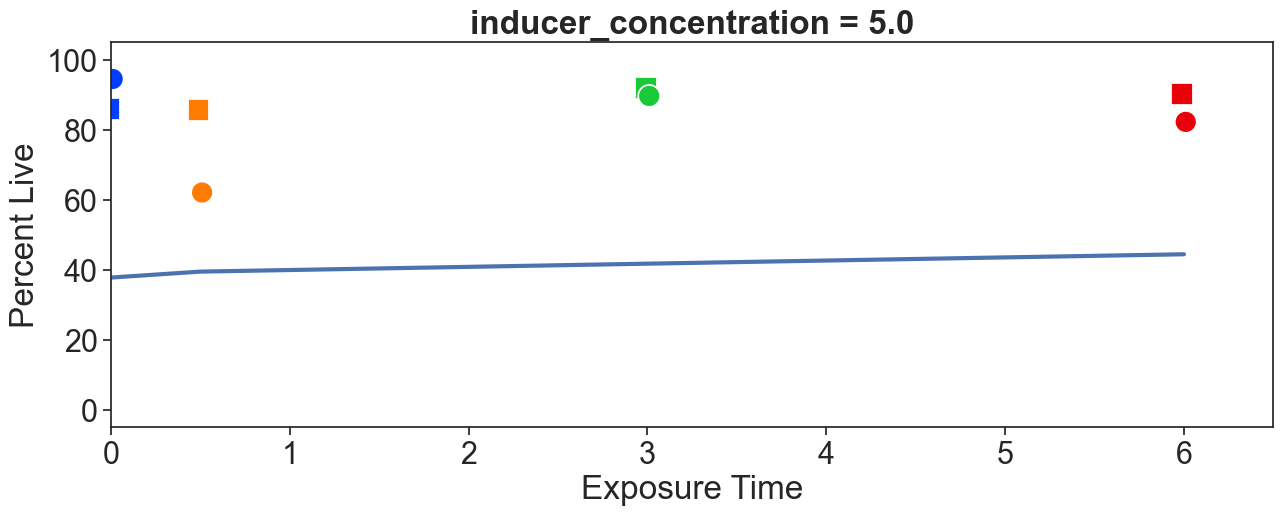

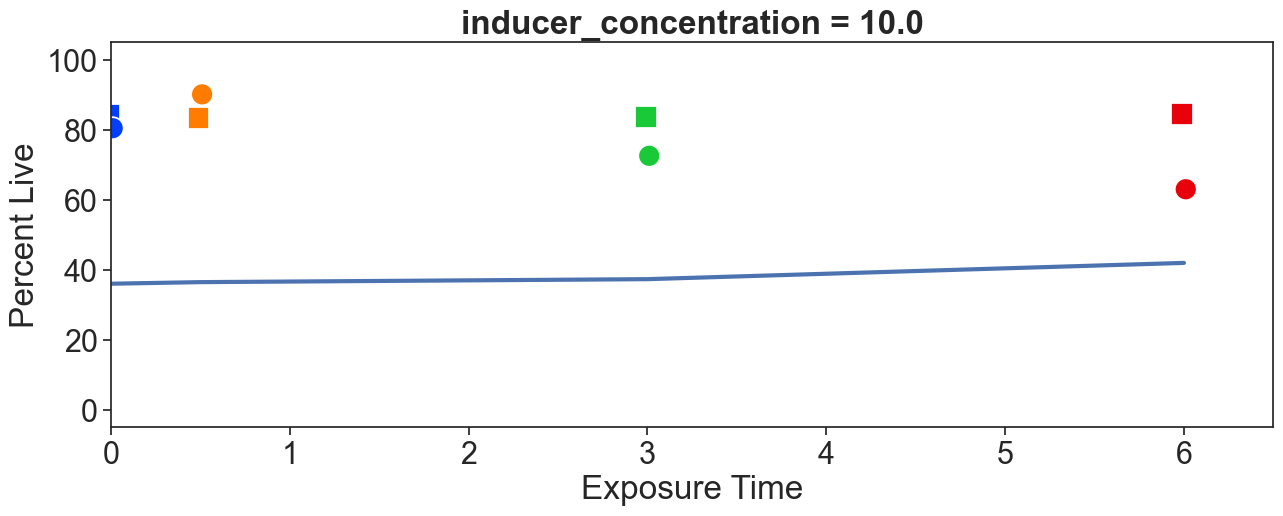

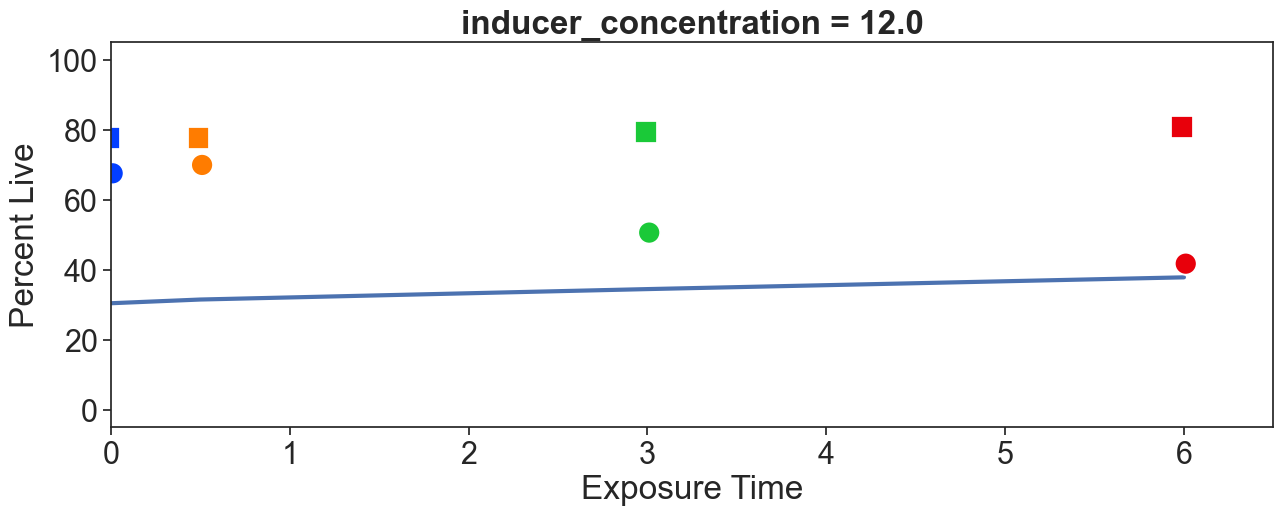

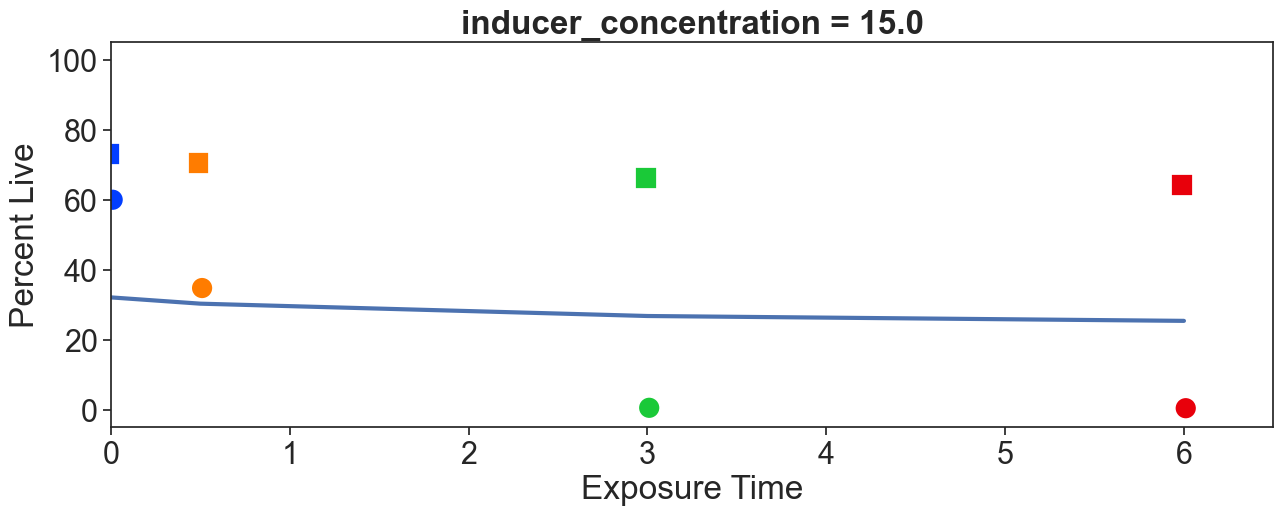

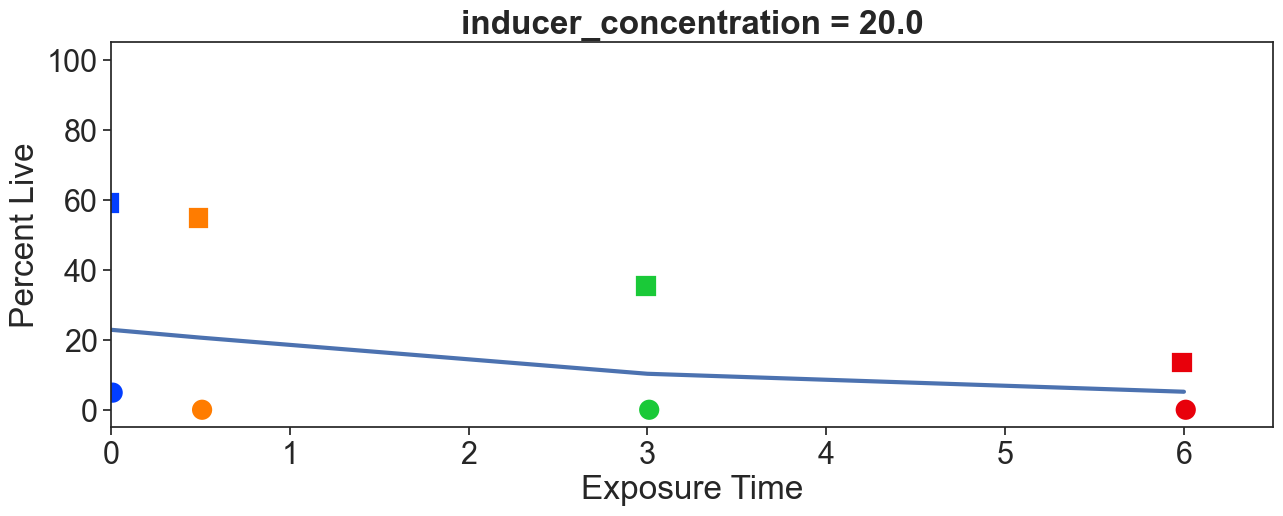

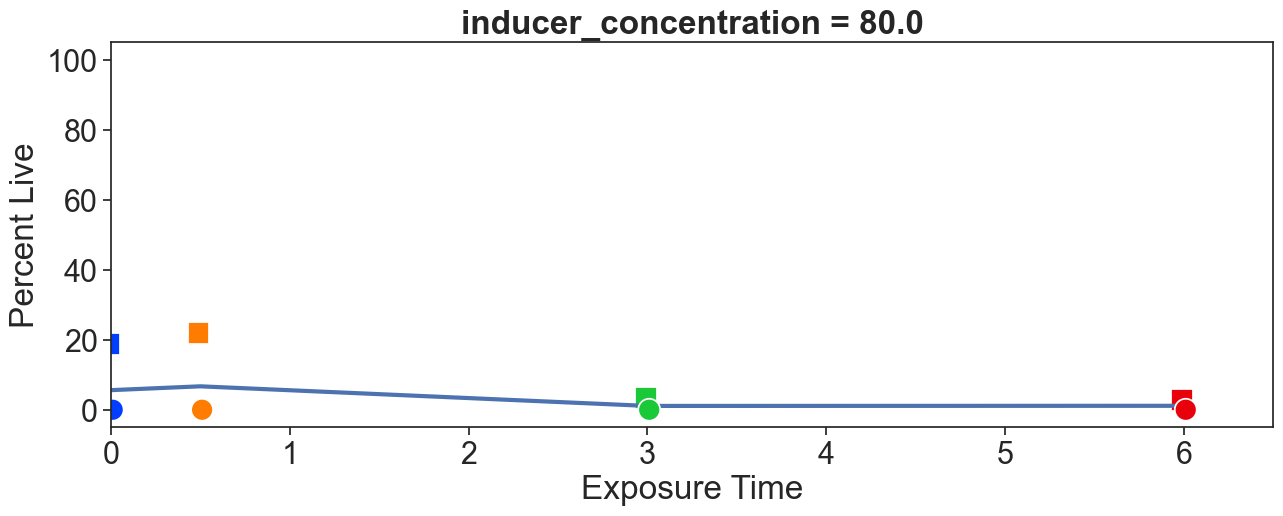

In [12]:
plot_per_cond(condition_results)

In [13]:
if use_stain_in_AutoGater:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels)
else:
    run_info = get_all_run_info(df_with_rfc_labels, X, preds_and_labels,
                                append_df_cols=stain_cols)

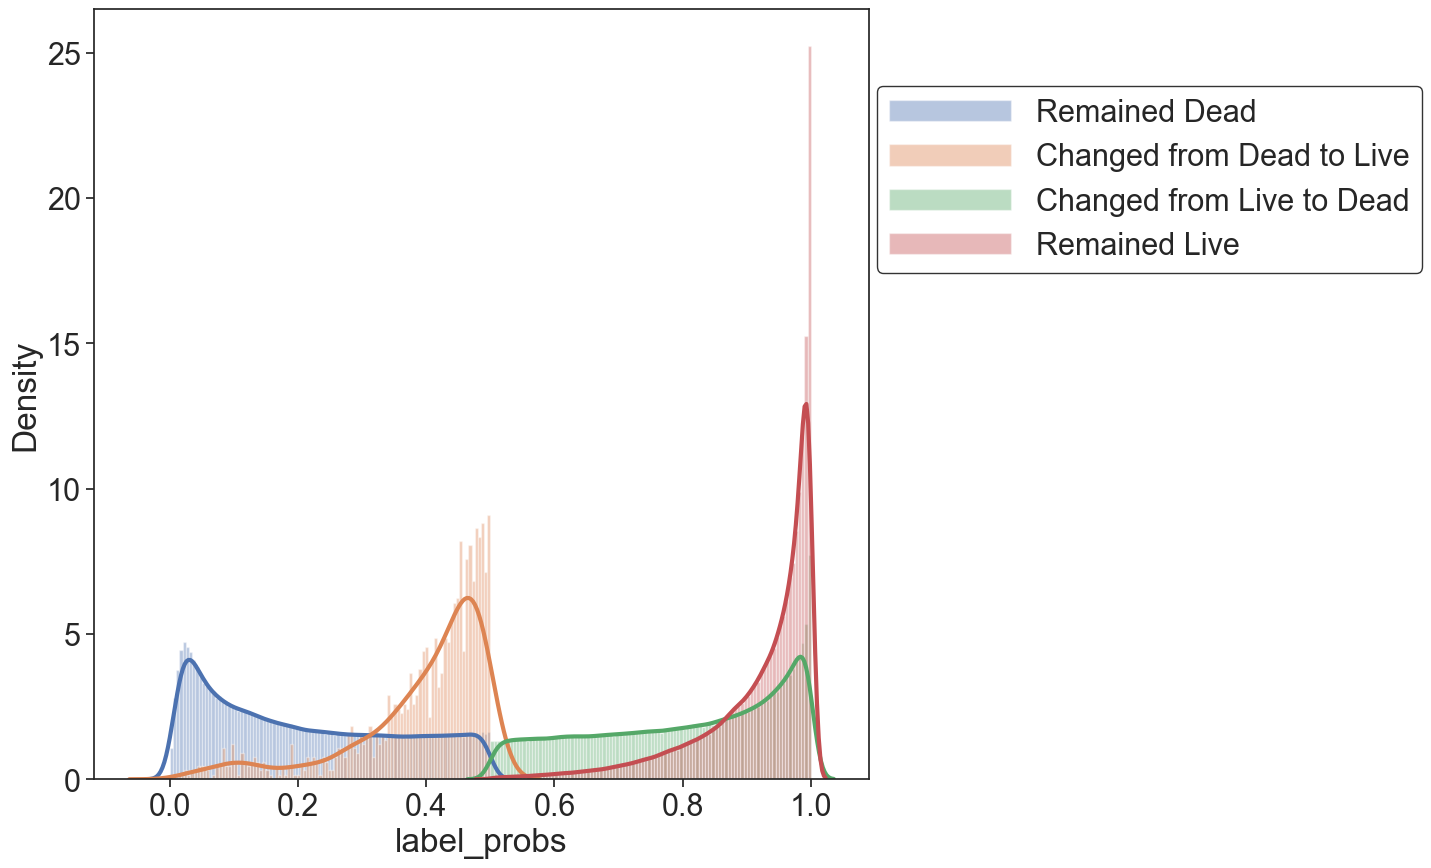

In [14]:
plot_prob_changes(run_info, None)

In [15]:
kde_df = get_conc_df_with_kde_values(run_info,
                                     conc="all",
                                     features=all_features,
                                     cc="{}-H".format(color_channel_to_use))

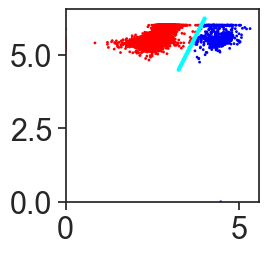

Percent of AutoGater live predictions that are left of the SOA dashed line: 94.86


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

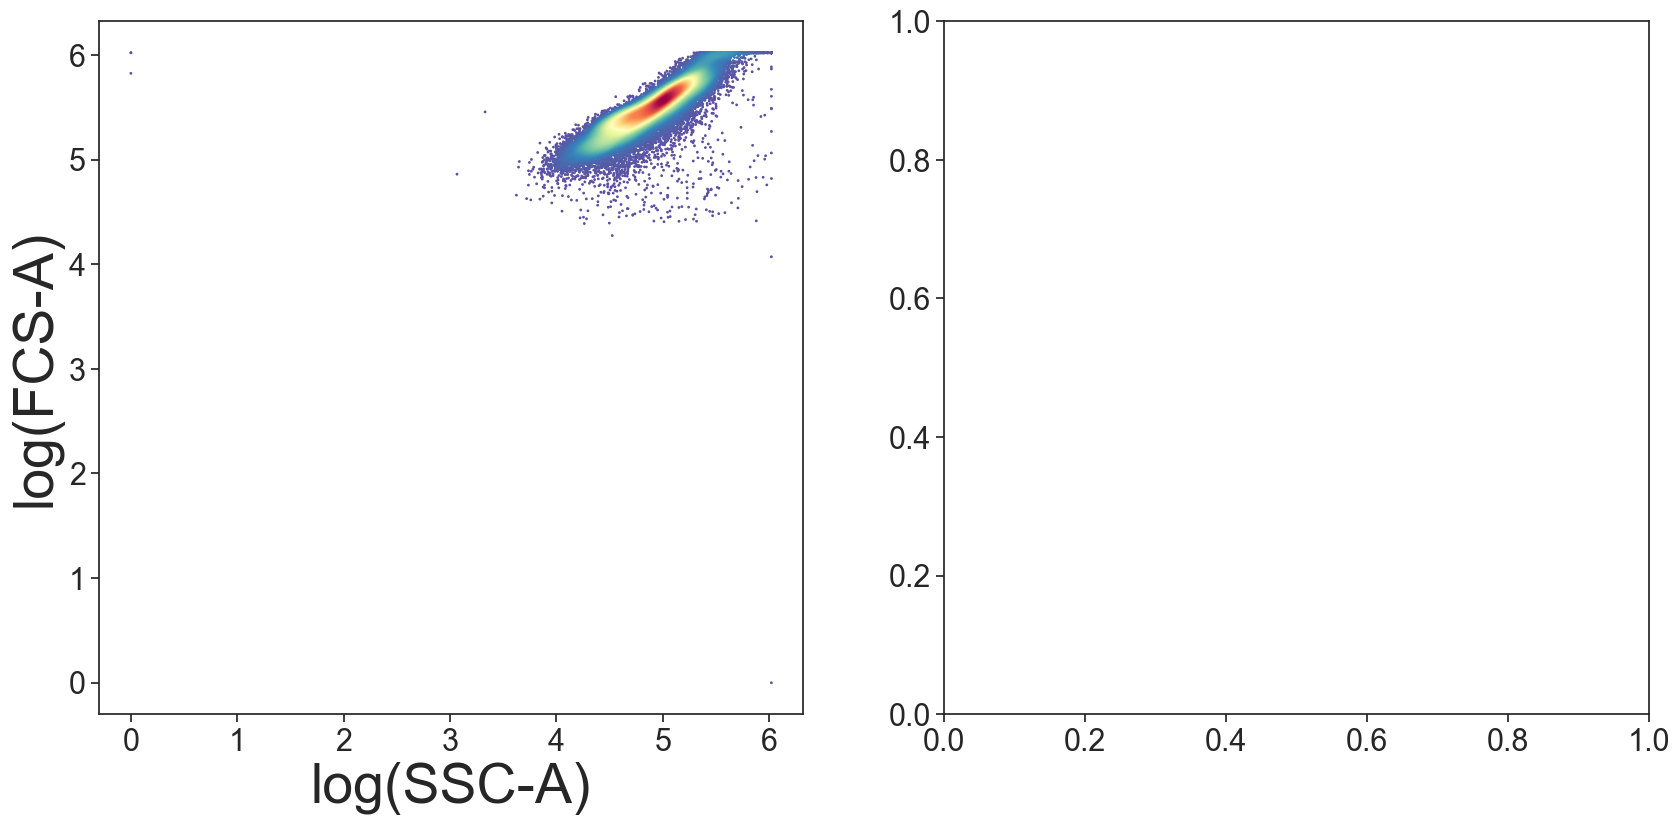

In [16]:
final_df = kde_scatter(kde_df, cc="{}-H".format(color_channel_to_use), logged=True,
                       fraction_of_points_based_on_kde=0.95,
                       point_1_that_defines_line=point_1_that_defines_soa_line, 
                       point_2_that_defines_line=point_2_that_defines_soa_line,
                       cmap="Spectral_r", pred_col="nn_preds", kmeans_sota=False)

In [ ]:
summary_table = summary_table_of_results(final_df)

In [ ]:
percent_live_comparison_plot(summary_table, legend=False)

In [ ]:
# summary_table_2 = summary_table.copy()
# summary_table_2.drop(columns="AutoGater", inplace=True)
# summary_table_2.rename(columns={"Weakly Supervised Model (RF)": "AutoGater"}, inplace=True)


In [ ]:
# percent_live_comparison_plot(summary_table_2)